We need a development environment that is capable to conducting all of our business requirements for our team. AWS offers multiple options asides from just EMR; such as Cloud9, Glue, Lambda and SageMaker to conduct these operations. Each has its own cost and benefits. 

The below is an instructional guide on how to setup an EMR Cluster for our business purposes.

# Create an EMR Cluster

- Go to *Amazon EMR* and select the *Clusters* option under the *EMR on EC2* header of the left-panel. Then select *Create cluster* in the main panel.
- Input a *Name* and keep the default *Amazon EMR release*.
- Under *Application bundle*, select *Custom*. Then select the *Spark*, *JupyterEnterpriseGateway*, *JupyterHub* and *Trino* options.
    - Note: Do note select both the *Trino* and *Presto* options as the cluster will fail if both of these are enabled.

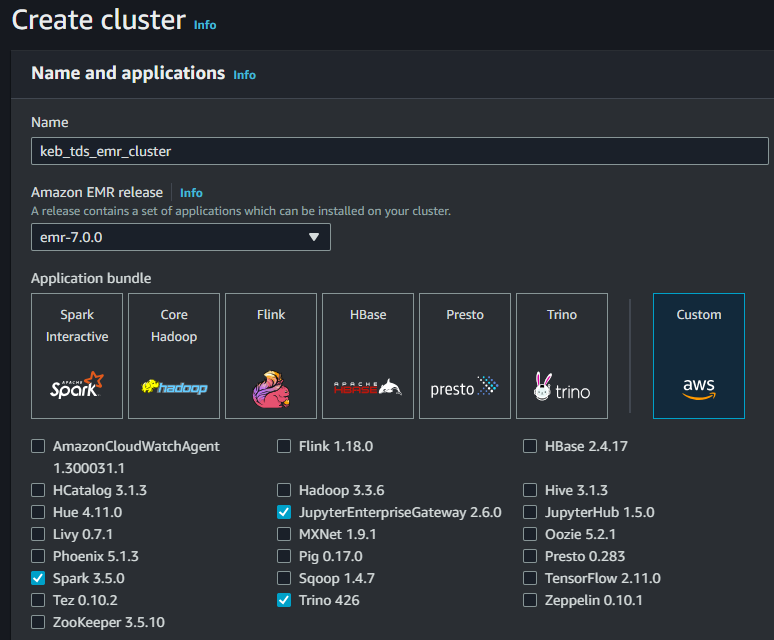

- You can change the *Cluster configurations* and *Cluster scaling and provisioning* to meet your use case needs but in this case, I am leaving them as its defaults.
- Under the *Networking* section, you will need to select the appropriate *VPC*, *Subnet* and *EC2 security groups (firewall)*.
- You will want to put a termination policy in place, so under the *Cluster termination* section, select *Automatically terminate cluster after idle time* and then select the appropriate amount of *idle time*. In this case, since we will leave it as the default of 1 hour.
    - In the Lambda function version example where I use EventBridge to spin up an EMR cluster at 7AM MT every weekday, the timeout is 12 hours so that the cluster doesn't shutdown in the middle of the day as people work on and off it for developement.

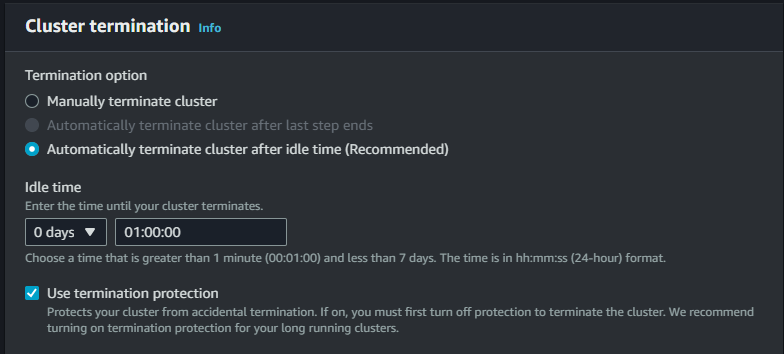

- You will want to change the default *Cluster logs* location to *aws-keb-shard/emr/clusters* directory. This bucket has a S3 LifeCycle policy in place of 7 days so that old logs are automatically removed from storage.

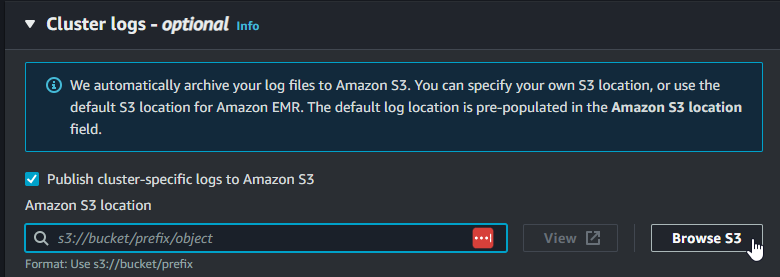

- In order to allow the cluster to run off an EC2 instance, you will need to bring in the *Amazon EC2 key pair for SSH to the cluster* found under the *Security configuration and EC2 key pair* section. If one doesn't exist, then you will need to create it in order for the cluster to work.

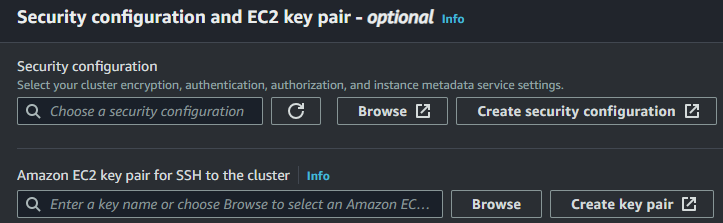

- Next, you will need to select a *Service role* and *Instance profile* under the *Identity and Access Management (IAM) roles* section.
- Finally, select *Create cluster*. This will take some time.

You can check on that status of the cluster in the *Clusters* section of the *EMR on EC2* header:

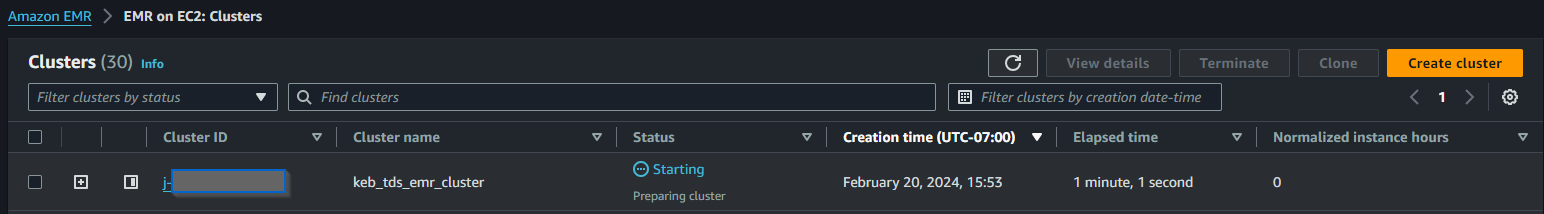

Once it changes from *Starting* to *Waiting* status, you can move on to the next step.

Note: You can terminate clusters from this menu as well. Terminated clusters can be cloned here as well, so unless you're changing the configurations, you can simply just clone your last terminated cluster rather then reconfiguring all the steps just mentioned above. Additionally, terminated cluster will remain in this menu for 2-3 months as per AWS's own internal policies. There will automatically be removed over time and there is no manner to eliminate them from this menu. If the terminated clusters are an issue and you only want to see active clusters, you can filter to only active clusters:

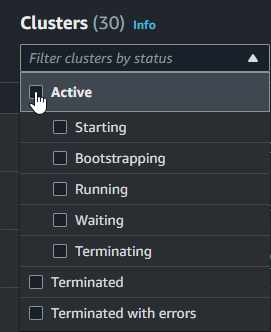

You can also see this in the AWS CLI by running the below command:

        aws emr list-clusters --active

# Create an EMR Studio & Workspace

If you haven't already done so, you will need to create an EMR Studio and Workspaces. Unlike the case with clusters, this really only needs to be provisioned once. To do this follow the below instructions:

- Under the *EMR Studio* header of the left-panel, select *Studios*.
- Select *Create studio*.
- Select *Custom* under the *Setup options*.
- Input a *Studio name* and optional *Description*.
- Select *Select existing location* under the *S3 location for Workspace storage* section. In our case, we'll use the aws-keb-shard/emr directory. Use the *Browse S3* option to select this folder.
- Select the appropriate service role.

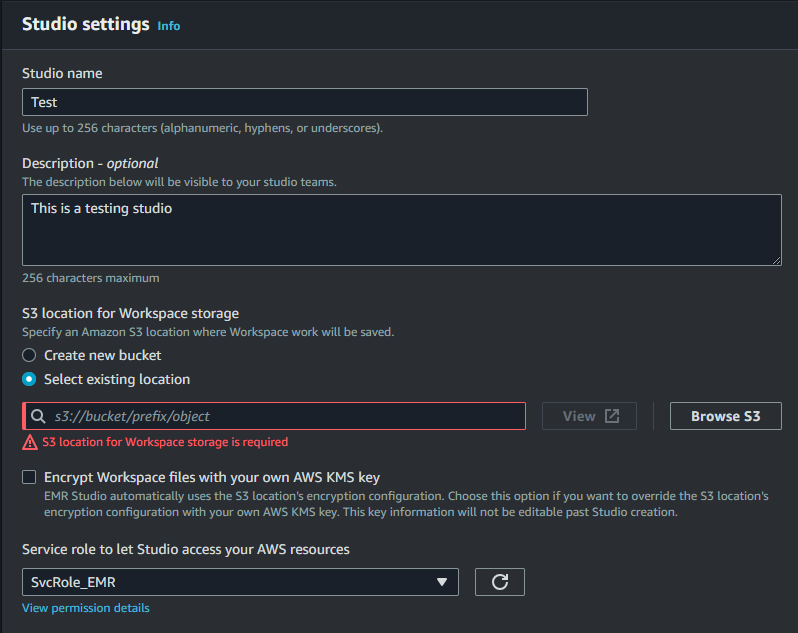

- Input a *Workspace name* under the *Workspace setting* section and enable *Allow collaboration*.

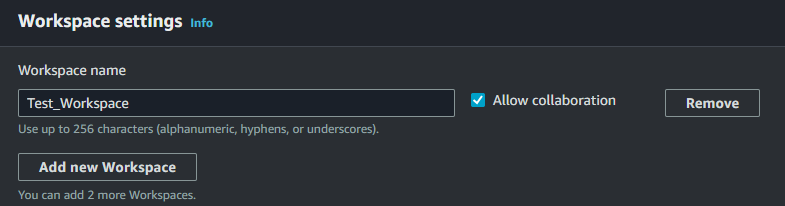

- Keep the defaults for the *Authentication* section.
- Select the appropriate *VPC* and *Subnet* under the *Networking and security* section.
- IMPORTANT: Ensure that the *Default security group* field is selected. If you use a custom security group, you'll have issues. Also make sure that *Enable clusters/endpoints and Git repository* is selected if you want to use GitHub.

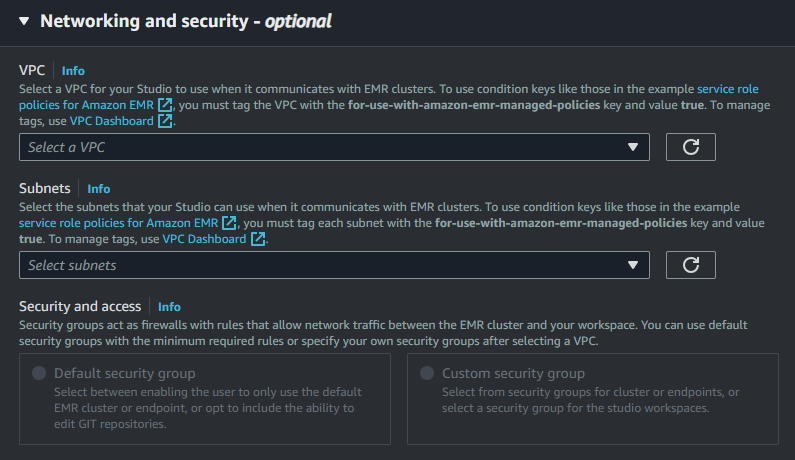

- Select *Create Studio and launch Workspace*.
- Wait until a new window opens for JupyterLab.

Note: Once the above is setup, there will be multiple ways to access the Workspace:

Method 1: 

- Click on *Studios* under the *EMR Studio* header of the left-panel and then select the URL under the *Studio Access URL*.

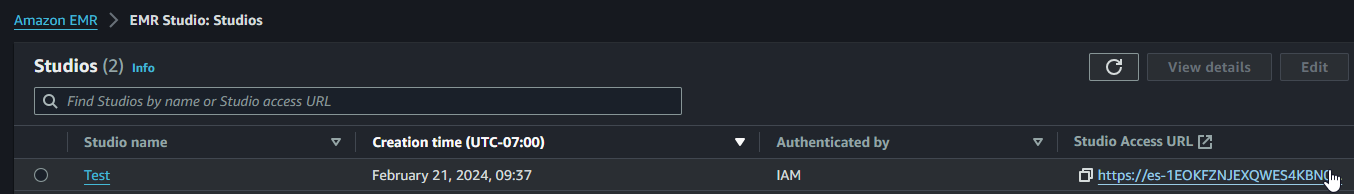

- Click on *Workspaces* in the left-panel, select the workspace and click *Launch Workspace* and then *Launch with options*.

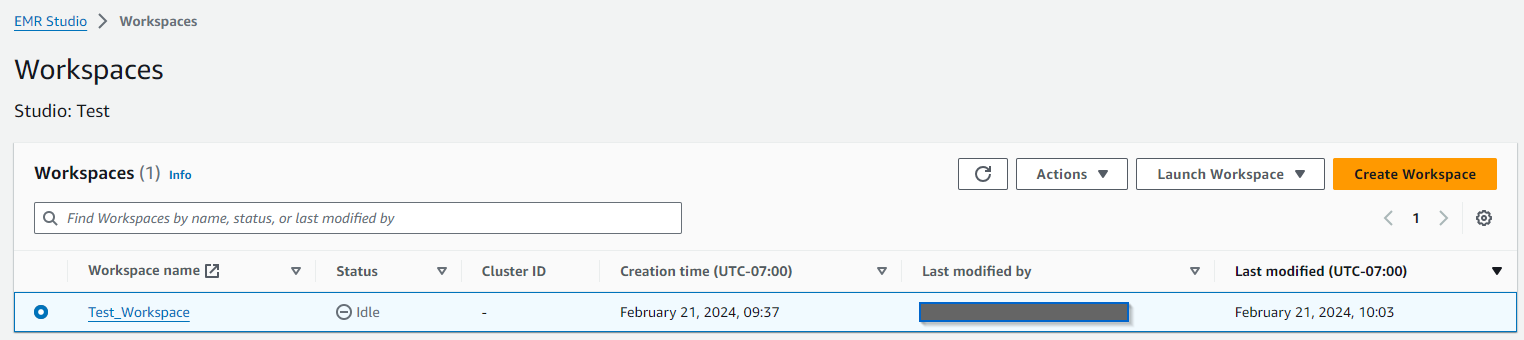

- A popup window will show and you'll been to select the active *EMR cluster*.
- Then select *Launch Workspace*. 
- Make sure that your browser isn't blocking the popup page for JupyterLabs. In a moment that popup will load a new page and you'll be in the Workspace.

Note: You can also select *Quick launch* but you'll have to attach the cluster in another step. If you choose this, then it will open a new JupyterLab window and you'll have to select *EMR Compute* in the left-panel.
    
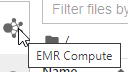

- Select the *EMR on EC2 cluster* option.
- Select the active cluster under the *EMR on EC2 cluster* dropdown.
- Select *Attach*.
    
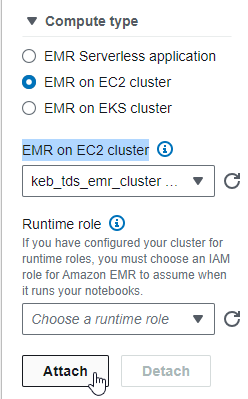

If all goes well, then you'll see this message:

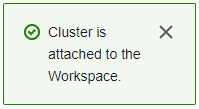

Method 2:

- Click on *Workspaces* under the *EMR Studio* header of the left-panel.
- Select the appropriate workspace and then click the *Attach cluster* option.

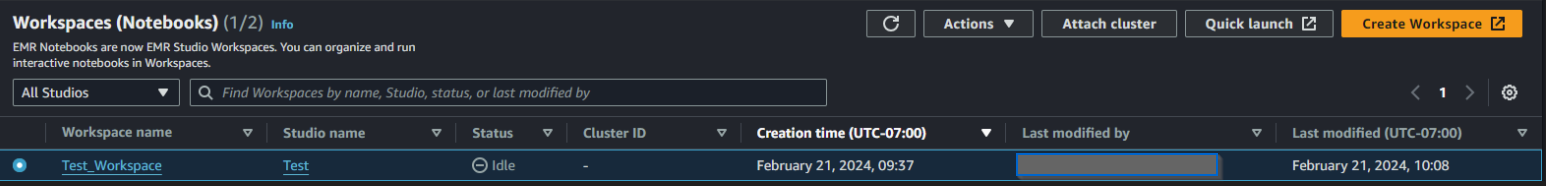

- Like in the first method, you'll have to click the active cluster and then select *Attach cluster and launch*. You can also do the *Quick launch* option instead but again will have to attach the cluster once in the workspace as documented in method 1.

# Linking to GitHub for Version Control

- In order to connect EMR to GitHub, you'll first need to get a *personal access token*. To get this go to GitHub, login, select your profile icon located in the top-right header, go to *Settings* then *Developer Settings* and finally *Personal access token*.
- Select *Token (classic)* then *Generate new token* and then *Generate new token (classic)*.
- Give the token a name in the *Note* input, define an *Expiration* policy and then select the *repo* policy in the *Select scopes* section.

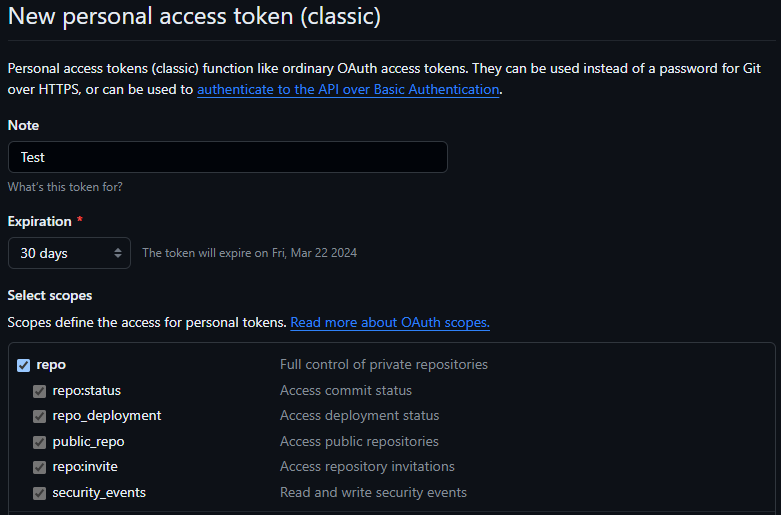

- Click *Generate token*.
- Copy the token and save it into AWS's Secrets Manager.
- Note: You may need to make sure that this token has access to specific organizations so that you can commit to team repos. Failure to do this will mean that this token will only let you commit to your own accounts repos. To do this select the *Configure SSO* option for the token of interest in the *Tokens (classic)* page mentioned earlier and select *Authorize* to the organizations that you would like to be able to commit to and pull from.

- Once that is all done, you can now close GitHub and go into your EMR Workspaces.
- Select the *EMR Git Repository* option in the left-panel of EMR Workspaces.

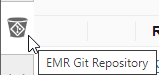

- Select *Add repo*.
- Input a name in the *Repo name* section.
- Copy and Paste the *Repository URL*.
- Enter the *Repository branch*.
- If you have already put the GitHub Personal Access Token into AWS Secrets Manager, then select *Use an existing AWS Secret* and then select the *Existing AWS Secret* from the dropdown and then select *Add repo*.

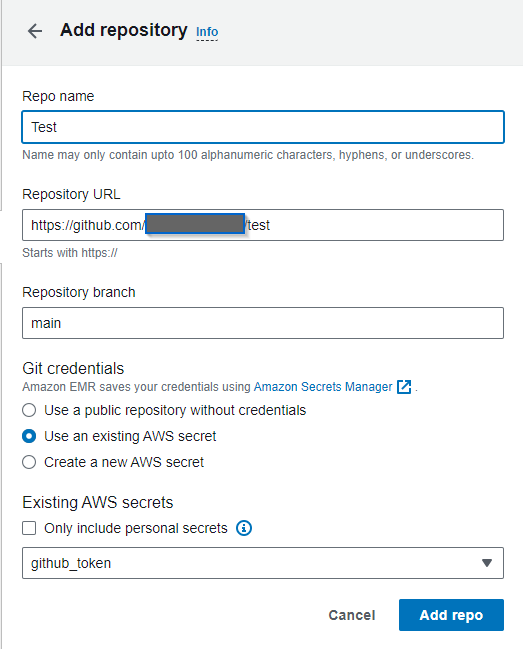

- Next, you'll need to select *Link* for it to initialize the connection. If successful you'll be ready for the next steps. If not, you may have to troubleshoot your own issues by unlinking and deleting the repo out of your Git repositories in EMR. This will require deactivating the lock logo to unlink; which is required to delete it. Most of the issues I came across with the inability to successfully link GitHub to EMR was due to the Security Group settings when launching the Workspaces. Make sure to keep the defaults in order to best avoid this.

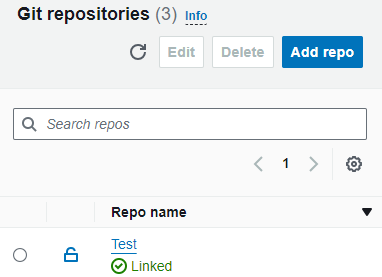









# Pull from GitHub Repo

- If you to the *File Browser* found in the left-panel, you'll now see a folder with the repo's name.

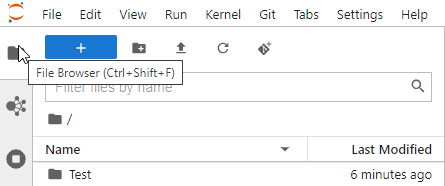

- If you click into that folder, you'll see the contents of the repo.

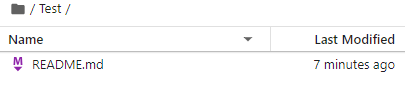

- Now if I add a file to that repo in GitHub since I linked it to EMR, it won't be seen here.
- For example, I just put this file into the repo but it isn't showing in the EMR File Browser for that repo even if I press the refresh button.

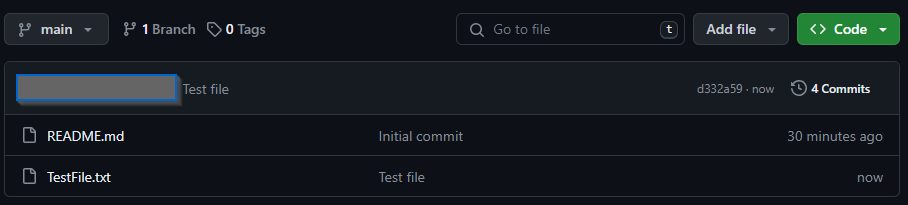

- To fix this, go to the *Git* menu in the left-panel and press the *Pull latest changes* button.

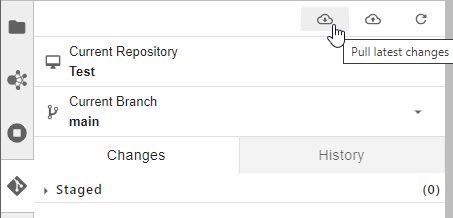

- Now if you go back to the *File Browser* this file will be available.

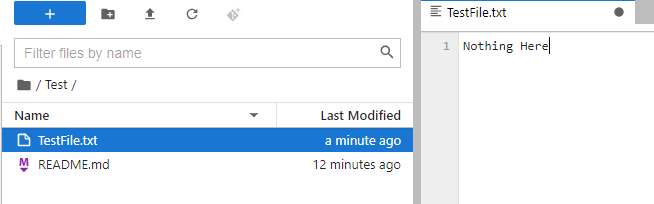

# Push back to GitHub

- If I add content to this file and then save it using the *Ctrl* + *s* keyboard shortcut, this change won't automatically be uploaded to GitHub.

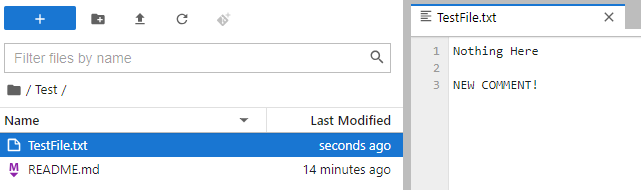

- Go back to the *Git* menu from the left-panel, hover over the file in the *Changed* section that you made changes to and want to be uploaded to GitHub and press the *+* button so that it moves to the *Staged* section.

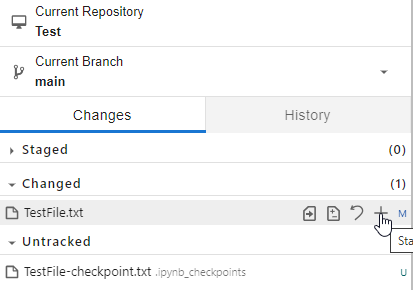

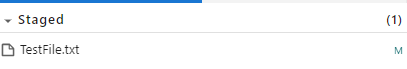

- Input a *Summary* comment describing the changes made and press *Commit*.

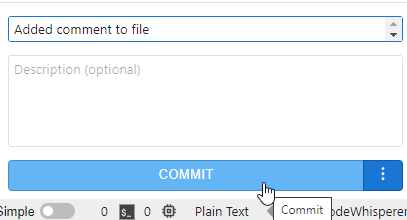

- Select the *Push commit changes* option above.

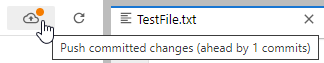

- And if you go into the file on GitHub, the changes have been successfully saved.

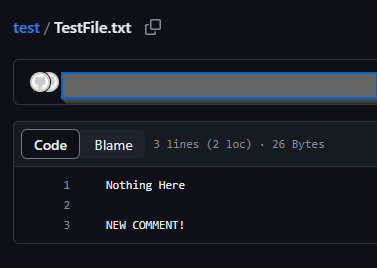